# 2. Data fetching and processing

In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path("../../").resolve()))

%load_ext autoreload
%autoreload 2

## More details about list_data

In [2]:
import pipeGEM as pg
from pipeGEM.data.fetching import list_models, load_model

In [3]:
model_list = list_models(organism="human")

In [4]:
model_list

,id,organism,reaction_count,metabolite_count,gene_count,database
1,Human-GEM,Homo sapiens,13070,8369,3067,metabolic atlas
1,iAB_RBC_283,Homo sapiens,469,342,346,BiGG
12,iAT_PLT_636,Homo sapiens,1008,738,636,BiGG
105,RECON1,Homo sapiens,3741,2766,1905,BiGG
106,Recon3D,Homo sapiens,10600,5835,2248,BiGG


In [5]:
# select by number of components

model_list = list_models(organism="mouse", 
                         max_n_genes=2000, max_n_mets=3000, max_n_rxns=5000)

In [6]:
model_list

,id,organism,reaction_count,metabolite_count,gene_count,database
77,iMM1415,Mus musculus,3726,2775,1375,BiGG


## Generate simulated gene data

In [3]:
from pipeGEM.data.synthesis import get_syn_gene_data
import seaborn as sns
import numpy as np

In [4]:
mouse = load_model('iMM1415')

Set parameter Username
Academic license - for non-commercial use only - expires 2023-06-14


No objective coefficients in model. Unclear what should be optimized


In [5]:
raw_count = get_syn_gene_data(mouse, n_sample=9, random_state=42)

In [6]:
raw_count.head()

,sample_0,sample_1,sample_2,sample_3,sample_4,sample_5,sample_6,sample_7,sample_8
12846,4163,4115,4058,4072,4153,4135,4012,4068,4004
67689,4063,4141,4117,4145,4061,4110,4091,4031,3938
237940,4093,4152,4121,4003,4050,4168,4133,3974,4053
222,4127,4099,3910,3994,4090,4250,4082,4081,4063
76507,4012,4025,4005,4081,4040,4038,4074,4175,4138


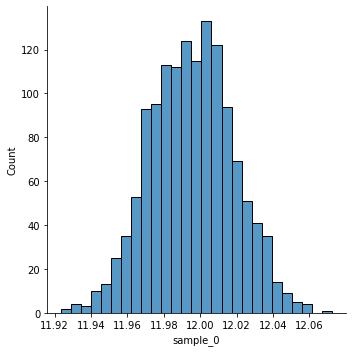

In [7]:
# should be negative binomial distribution

sns.displot(np.log2(raw_count + 1)["sample_0"])

## Maping gene data to a pipeGEM model

In [9]:
from pipeGEM.data import GeneData

In [20]:
p_mouse = pg.Model("imm1415", mouse)

In [16]:
gene_data = GeneData(data=raw_count["sample_0"], 
                     data_transform=lambda x: np.log2(x), 
                     absent_expression=-np.inf)

In [21]:
p_mouse.add_gene_data(name_or_prefix="sample_0", 
                      data=gene_data, 
                      or_operation="nanmax",  # alternative: nansum
                      threshold=-np.inf, 
                      absent_value=-np.inf)

In [27]:
p_mouse.reactions.get_by_id("2HBt2")

Reaction identifier,2HBt2
Name,2 hydroxybutyrate cotransport with proton
Memory address,0x0209c9613eb0
Stoichiometry,2hb_e + h_e <=> 2hb_c + h_c 2 Hydroxybutyrate C4H7O3 + H+ <=> 2 Hydroxybutyrate C4H7O3 + H+
GPR,80879 or 20503 or 20501
Lower bound,-100000.0
Upper bound,100000.0


In [28]:
p_mouse.gene_data["sample_0"].rxn_scores["2HBt2"]

11.98299357469431

In [31]:
gene_data.gene_data["80879"], gene_data.gene_data["20503"], gene_data.gene_data["20501"]

(11.98299357469431, 11.972261848733291, 11.971543553950772)

## Visualizing gene data

In [10]:
gene_data_dict = {k: GeneData(data=v, 
                              data_transform=lambda x: np.log2(x), 
                              absent_expression=-np.inf) 
                  for k, v in raw_count.items()}

In [11]:
gene_data_dict

{'sample_0': <pipeGEM.data.data.GeneData at 0x25cd20ac280>,
 'sample_1': <pipeGEM.data.data.GeneData at 0x25cd20ac340>,
 'sample_2': <pipeGEM.data.data.GeneData at 0x25cd20ac4f0>,
 'sample_3': <pipeGEM.data.data.GeneData at 0x25cd20ac580>,
 'sample_4': <pipeGEM.data.data.GeneData at 0x25cd20ac670>,
 'sample_5': <pipeGEM.data.data.GeneData at 0x25cd20ac790>,
 'sample_6': <pipeGEM.data.data.GeneData at 0x25cd20ac880>,
 'sample_7': <pipeGEM.data.data.GeneData at 0x25cd20ac910>,
 'sample_8': <pipeGEM.data.data.GeneData at 0x25cd20ac970>}

In [12]:
agg_data = GeneData.aggregate(gene_data_dict, prop="data")

In [15]:
corr_result = agg_data.corr()

,sample_0,sample_1,sample_2,sample_3,sample_4,sample_5,sample_6,sample_7,sample_8
sample_0,1.000000,-0.019768,-0.030866,0.023345,-0.016708,0.020136,0.004408,0.001422,0.027229
sample_1,-0.019768,1.000000,-0.003563,-0.013306,-0.015332,-0.010605,-0.003146,0.049430,-0.016304
sample_2,-0.030866,-0.003563,1.000000,0.025437,-0.025465,-0.029224,-0.035789,-0.019060,-0.018303
sample_3,0.023345,-0.013306,0.025437,1.000000,-0.011472,0.035821,-0.025553,0.015618,-0.003134
sample_4,-0.016708,-0.015332,-0.025465,-0.011472,1.000000,0.018340,0.030272,-0.013200,-0.034380
sample_5,0.020136,-0.010605,-0.029224,0.035821,0.018340,1.000000,0.001410,0.027424,-0.048966
sample_6,0.004408,-0.003146,-0.035789,-0.025553,0.030272,0.001410,1.000000,0.021957,0.022836
sample_7,0.001422,0.049430,-0.019060,0.015618,-0.013200,0.027424,0.021957,1.000000,-0.027944
sample_8,0.027229,-0.016304,-0.018303,-0.003134,-0.034380,-0.048966,0.022836,-0.027944,1.000000


In [14]:
plot_PCA(np.log2(raw_count + 1), groups=None)

NameError: name 'plot_PCA' is not defined

saving  None


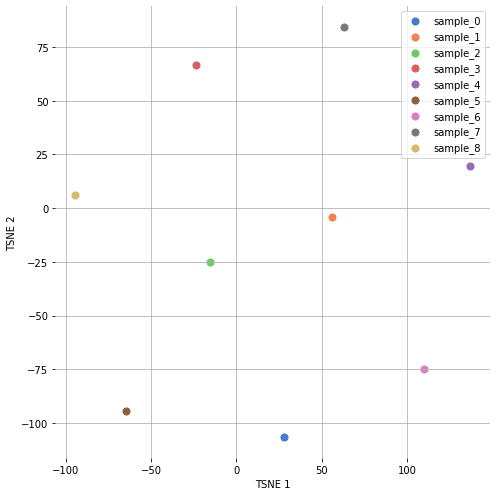

{'g': <Figure size 504x504 with 1 Axes>}

In [65]:
plot_embedding(np.log2(raw_count + 1), reducer="TSNE")

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/umap_.py:2214: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


saving  None


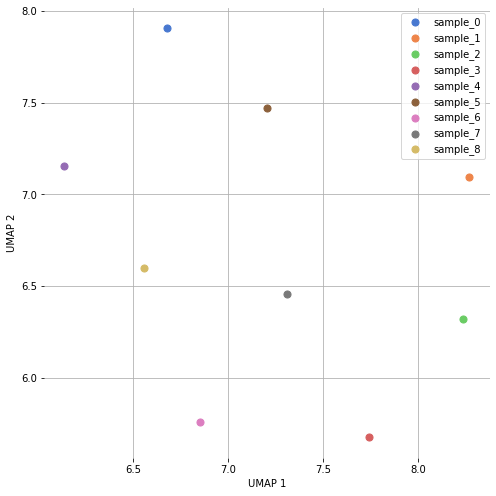

{'g': <Figure size 504x504 with 1 Axes>}

In [64]:
plot_embedding(np.log2(raw_count + 1), reducer="UMAP")

## Protein data fetcher

pipeGEM provides an API to fetch HPA data and to process it,
the data could be found in https://www.proteinatlas.org/about/download

In [66]:
from pipeGEM.pipeline.preprocessing import HPADataFetcher

In [71]:
hpa_data = HPADataFetcher("normal_tissue", data_path="./")

In [73]:
hpa_data()

fetching data...
Data is downloaded and saved in  .
The dataframe is already exist.
[]
Using Fastcormic thresholds
[]
Using Fastcormic thresholds
The dataframe is already exist.
The dataframe is already exist.
[]
Using Fastcormic thresholds
[]
Using Fastcormic thresholds


{'data_df': Empty DataFrame
 Columns: []
 Index: [],
 'used_rxn_thres': None}

## Medium data

In [38]:
human = load_model("Human-GEM")

NotImplementedError: haven't finished